In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
sheet_name = 'Sheet1'
df = pd.read_excel("./compounds.xlsx", sheet_name = sheet_name)
# df = df.dropna(subset = ['chemical'])
# # df = df.dropna()
# df = df.dropna(subset = ['Isomeric SMILES', 'Canonical SMILES'], how = 'all')

In [4]:

weight = []
logp = []
h_bond_donor = []
h_bond_acceptors = []
for i, row in df.iterrows():

    if ((not isinstance(row['chem'], str)) or 
        (not isinstance(row.get('smile', None), str)) ):
        weight.append(None)
        logp.append(None)
        h_bond_donor.append(None)
        h_bond_acceptors.append(None)
        continue

    try:
        molecule = Chem.MolFromSmiles(row['smile'])

    except:
        molecule = Chem.MolFromSmiles(row['Isomeric SMILES'])
    weight.append(Descriptors.ExactMolWt(molecule))
    logp.append(Descriptors.MolLogP(molecule))
    h_bond_donor.append(Descriptors.NumHDonors(molecule))
    h_bond_acceptors.append(Descriptors.NumHAcceptors(molecule))

df['weight'] = weight
df['logp'] = logp
df['h_bond_donor'] = h_bond_donor
df['h_bond_acceptors'] = h_bond_acceptors

df['weight_pass'] = df['weight'] < 500
df['logp_pass'] = df['logp'] <5
df['h_bond_donor_pass'] = df['h_bond_donor'] < 5
df['h_bond_acceptors_pass'] = df['h_bond_acceptors'] < 10

df['weight_pass'][df['weight'].apply(np.isnan)] = None
df['logp_pass'][df['weight'].apply(np.isnan)] = None
df['h_bond_donor_pass'][df['weight'].apply(np.isnan)] = None
df['h_bond_acceptors_pass'][df['weight'].apply(np.isnan)] = None

df['summary'] =  df[['weight_pass', 'logp_pass', 'h_bond_donor_pass','h_bond_acceptors_pass']].sum(axis = 1)
df['summary'][df['weight'].apply(np.isnan)] = -1

C:\Users\dream\AppData\Local\Temp\ipykernel_20100\672696220.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['weight_pass'][df['weight'].apply(np.isnan)] = None
C:\Users\dream\AppData\Local\Temp\ipykernel_20100\672696220.py:35: Settin

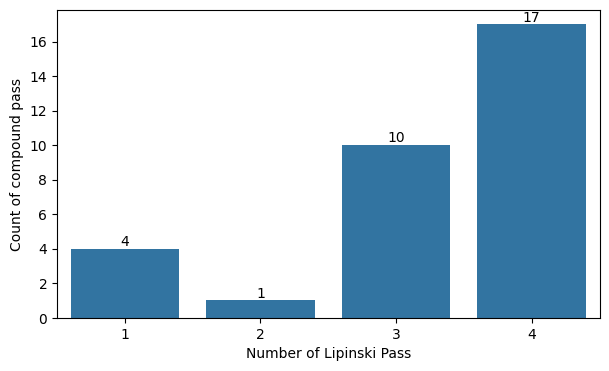

In [5]:
df_plot = deepcopy(df[df['summary']>0])
plt.figure(figsize=(7, 4))

ax = sns.barplot(
    x = df_plot['summary'].value_counts().keys(), 
    y = df_plot['summary'].value_counts().values)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel='Number of Lipinski Pass', ylabel='Count of compound pass')
plt.savefig('total.png', dpi=800, bbox_inches='tight')

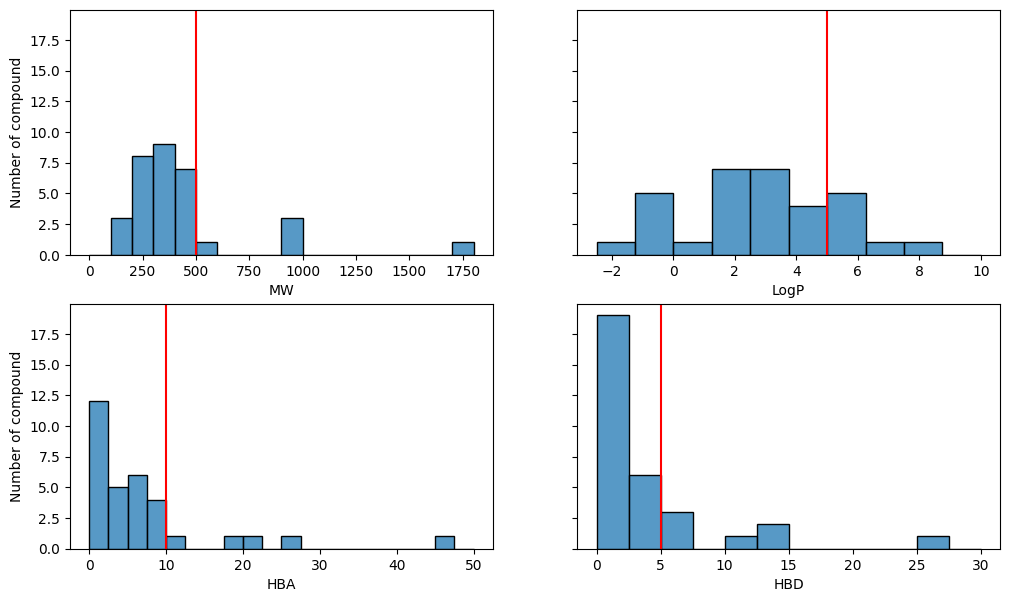

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharey=True)

# Bulbasaur
sns.histplot(df_plot['weight'], binwidth = 100, binrange=(0, 1800),ax = axes[0][0])
sns.histplot(df_plot['logp'], binwidth=1.25, binrange=(-2.5,10),ax = axes[0][1])
sns.histplot(df_plot["h_bond_acceptors"], binwidth=2.5, binrange=(0,50),ax = axes[1][0])
sns.histplot(df_plot["h_bond_donor"], binwidth=2.5, binrange=(0,30),ax = axes[1][1])

axes[0][0].set_xlabel("MW")
axes[0][1].set_xlabel("LogP")
axes[1][0].set_xlabel("HBA")
axes[1][1].set_xlabel("HBD")

axes[0][0].set_ylabel("Number of compound")
axes[0][1].set_ylabel("Number of compound")
axes[1][0].set_ylabel("Number of compound")
axes[1][1].set_ylabel("Number of compound")

axes[0][0].axvline(x=500, color = 'r')
axes[0][1].axvline(x=5, color = 'r')
axes[1][0].axvline(x=10, color = 'r')
axes[1][1].axvline(x=5, color = 'r')

plt.savefig('each.png', dpi=800, bbox_inches='tight')

In [73]:
use_columns = [ 'weight_pass', 'logp_pass',
       'h_bond_donor_pass', 'h_bond_acceptors_pass']

for col in use_columns:
    df_plot[col][df_plot[col] == True] = '√'
    df_plot[col][df_plot[col] == False] = 'x'

C:\Users\dream\AppData\Local\Temp\ipykernel_15816\3768352941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot[col][df_plot[col] == True] = '√'
C:\Users\dream\AppData\Local\Temp\ipykernel_15816\3768352941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot[col][df_plot[col] == False] = 'x'


In [60]:
df_plot['weight_pass'][df_plot['weight_pass'] == True] = ''
df_plot.to_csv(f"{sheet_name}_results.csv", index=False)